In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import sys

print("TensorFlow:",tf.__version__)
print("Python:", sys.version)
print("OpenCV:", cv2.__version__)

plt.rcParams['font.size'] = 18

TensorFlow: 2.7.0
Python: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
OpenCV: 4.1.2


In [2]:
class InputToCx(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(InputToCx, self).__init__()
        self.output_dim = output_dim

    def call(self, inputs, **kwargs):
        real = inputs * tf.cos(0.0)
        imag = inputs * tf.sin(0.0)
        return tf.stack([real, imag], axis=1)

In [3]:
class CxMO(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(CxMO, self).__init__()
        self.output_dim = output_dim

    # input[0,:,:] = real
    # input[1,:,:] = image
    def build(self, input_dim):
        self.phi = self.add_variable("phi",
                                     shape=[int(input_dim[-2]),
                                            int(input_dim[-1])])

        super(CxMO, self).build(input_dim)

    def call(self, x):
        x_real = Lambda(lambda x: x[: ,0, :, :], output_shape=self.output_dim)(x)  # real
        x_imag = Lambda(lambda x: x[: ,1, :, :], output_shape=self.output_dim)(x)  # imag
        mo_real = tf.cos(self.phi)
        mo_imag = tf.sin(self.phi)

        real = x_real * mo_real - x_imag * mo_imag
        imag = x_real * mo_imag + x_imag * mo_real
        cmpx = tf.stack([real, imag], axis=1)
        return cmpx

In [14]:
class FreeSpacePropagation(tf.keras.layers.Layer):
    def __init__(self, output_dim, k, z, input_pitch=1e-6, output_pitch=1e-6, normalization=None):
        super(FreeSpacePropagation, self).__init__()
        self.output_dim = output_dim
        self.input_pitch = input_pitch
        self.output_pitch = output_pitch
        self.z = z
        self.k = k
        self.normalization = normalization

    def build(self, input_shape):

        x1 = np.arange(0, input_shape[-1], 1)
        y1 = np.arange(0, input_shape[-2], 1)
        xx1, yy1 = np.meshgrid(x1, y1)
        xx1 = xx1.reshape(-1, 1) - input_shape[-1]/2
        yy1 = yy1.reshape(-1, 1) - input_shape[-2]/2

        x2 = np.arange(0, self.output_dim[1], 1)
        y2 = np.arange(0, self.output_dim[0], 1)
        xx2, yy2 = np.meshgrid(x2, y2)
        xx2 = xx2.reshape(1, -1) - self.output_dim[1]/2
        yy2 = yy2.reshape(1, -1) - self.output_dim[0]/2

        dx = (self.output_pitch * xx2 - self.input_pitch * xx1)
        dy = (self.output_pitch * yy2 - self.input_pitch * yy1)
        r = np.sqrt(dx**2 + dy**2 + self.z**2)
        w = 1/(2*np.pi) * self.z / r * (1/r - 1j*self.k) * np.exp(1j * self.k * r)

        self.w_real = tf.Variable(initial_value=w.real.astype('float32'),
                                              trainable=False)
        self.w_imag = tf.Variable(initial_value=w.imag.astype('float32'),
                                              trainable=False)

        super(FreeSpacePropagation, self).build(input_shape)

    def call(self, x, **kwargs):
        x_real = Lambda(lambda x: x[:,0, :, :], output_shape=(self.output_dim,))(x)  # real
        x_imag = Lambda(lambda x: x[:,1, :, :], output_shape=(self.output_dim,))(x)  # imag
        x_real = tf.reshape(x_real, (-1, x.shape[-1]*x.shape[-2]))
        x_imag = tf.reshape(x_imag, (-1, x.shape[-1]*x.shape[-2]))
        real = tf.matmul(x_real, self.w_real) - tf.matmul(x_imag, self.w_imag)
        imag = tf.matmul(x_imag, self.w_real) + tf.matmul(x_real, self.w_imag)
        real = tf.reshape(real, (-1, self.output_dim[0], self.output_dim[1]))
        imag = tf.reshape(imag, (-1, self.output_dim[0], self.output_dim[1]))
        if self.normalization == 'max':
            absmax = tf.reduce_max(tf.sqrt(real**2 + imag**2))
            real = real / absmax
            imag = imag / absmax
        cmpx = tf.stack([real, imag], axis=1)
        return cmpx


In [5]:
class CxD2NNMNISTDetector(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation=None, **kwargs):
        super(CxD2NNMNISTDetector, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.activation = activation

    def build(self, input_shape):
        self.input_dim = input_shape
        self.width = min(int(tf.floor(self.input_dim[2]/9.0)), int(tf.floor(self.input_dim[1]/7.0)))
        self.height = min(int(tf.floor(self.input_dim[2]/9.0)), int(tf.floor(self.input_dim[1]/7.0)))
        super(CxD2NNMNISTDetector, self).build(input_shape)

    def plot_area(self, input_shape, same_color=False):
        width =  min(int(np.floor(input_shape[1]/9.0)), int(np.floor(input_shape[0]/7.0)))
        height = min(int(np.floor(input_shape[1]/9.0)), int(np.floor(input_shape[0]/7.0)))
        x = np.zeros(input_shape)
        if same_color:
            x[2*height:3*height, width:2*width] = 1
            x[2*height:3*height, 4*width:5*width] = 1
            x[2*height:3*height, 7*width:8*width] = 1
            x[4*height:5*height, 1*width:2*width] = 1
            x[4*height:5*height, 3*width:4*width] = 1
            x[4*height:5*height, 5*width:6*width] = 1
            x[4*height:5*height, 7*width:8*width] = 1
            x[6*height:7*height, width:2*width] = 1
            x[6*height:7*height, 4*width:5*width] = 1
            x[6*height:7*height, 7*width:8*width] = 1
        else:
            x[2*height:3*height, width:2*width] = 1
            x[2*height:3*height, 4*width:5*width] = 2
            x[2*height:3*height, 7*width:8*width] = 3
            x[4*height:5*height, 1*width:2*width] = 4
            x[4*height:5*height, 3*width:4*width] = 5
            x[4*height:5*height, 5*width:6*width] = 6
            x[4*height:5*height, 7*width:8*width] = 7
            x[6*height:7*height, width:2*width] = 8
            x[6*height:7*height, 4*width:5*width] = 9
            x[6*height:7*height, 7*width:8*width] = 10
        plt.imshow(x)

    def call(self, x, **kwargs):
        y0 = x[:, 2*self.height:3*self.height, self.width:2*self.width]
        y1 = x[:, 2*self.height:3*self.height, 4*self.width:5*self.width]
        y2 = x[:, 2*self.height:3*self.height, 7*self.width:8*self.width]
        y3 = x[:, 4*self.height:5*self.height, self.width:2*self.width]
        y4 = x[:, 4*self.height:5*self.height, 3*self.width:4*self.width]
        y5 = x[:, 4*self.height:5*self.height, 5*self.width:6*self.width]
        y6 = x[:, 4*self.height:5*self.height, 7*self.width:8*self.width]
        y7 = x[:, 6*self.height:7*self.height, self.width:2*self.width]
        y8 = x[:, 6*self.height:7*self.height, 4*self.width:5*self.width]
        y9 = x[:, 6*self.height:7*self.height, 7*self.width:8*self.width]
        y0 = tf.reduce_sum(y0, axis=[1])
        y0 = tf.reduce_sum(y0, axis=[1], keepdims=True)
        y1 = tf.reduce_sum(y1, axis=[1])
        y1 = tf.reduce_sum(y1, axis=[1], keepdims=True)
        y2 = tf.reduce_sum(y2, axis=[1])
        y2 = tf.reduce_sum(y2, axis=[1], keepdims=True)
        y3 = tf.reduce_sum(y3, axis=[1])
        y3 = tf.reduce_sum(y3, axis=[1], keepdims=True)
        y4 = tf.reduce_sum(y4, axis=[1])
        y4 = tf.reduce_sum(y4, axis=[1], keepdims=True)
        y5 = tf.reduce_sum(y5, axis=[1])
        y5 = tf.reduce_sum(y5, axis=[1], keepdims=True)
        y6 = tf.reduce_sum(y6, axis=[1])
        y6 = tf.reduce_sum(y6, axis=[1], keepdims=True)
        y7 = tf.reduce_sum(y7, axis=[1])
        y7 = tf.reduce_sum(y7, axis=[1], keepdims=True)
        y8 = tf.reduce_sum(y8, axis=[1])
        y8 = tf.reduce_sum(y8, axis=[1], keepdims=True)
        y9 = tf.reduce_sum(y9, axis=[1])
        y9 = tf.reduce_sum(y9, axis=[1], keepdims=True)
        y = tf.keras.layers.concatenate([y0, y1, y2, y3, y4, y5, y6, y7, y8, y9])

        if self.activation == 'softmax':
            y = tf.nn.softmax(y)
        return y

In [6]:
class CxD2NNIntensity(tf.keras.layers.Layer):
    def __init__(self, output_dim, normalization='min_max', **kwargs):
        super(CxD2NNIntensity, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.normalization = normalization

    def call(self, x, **kwargs):
        real = Lambda(lambda x: x[:, 0, :, :])(x)
        image = Lambda(lambda x: x[:, 1, :, :])(x)
        intensity = tf.sqrt(real ** 2 + image ** 2)
        if self.normalization == 'min_max':
            max = tf.reduce_max(intensity)
            min = tf.reduce_min(intensity)
            intensity = (intensity - min)/(max - min)
        if self.normalization == 'max':
            max = tf.reduce_max(intensity)
            intensity = intensity / max

        return intensity

In [7]:
def create_true_mnistimage(label, shape):
    width =  min(int(np.floor(shape[1]/9.0)), int(np.floor(shape[0]/7.0)))
    height = min(int(np.floor(shape[1]/9.0)), int(np.floor(shape[0]/7.0)))
    x = np.zeros(shape)
    
    if label == 0:
        x[2*height:3*height, width:2*width] = 1.0
    elif label == 1:
        x[2*height:3*height, 4*width:5*width] = 1.0
    elif label == 2:
        x[2*height:3*height, 7*width:8*width] = 1.0
    elif label == 3:
        x[4*height:5*height, 1*width:2*width] = 1.0
    elif label == 4:
        x[4*height:5*height, 3*width:4*width] = 1.0
    elif label == 5:
        x[4*height:5*height, 5*width:6*width] = 1.0
    elif label == 6:
        x[4*height:5*height, 7*width:8*width] = 1.0
    elif label == 7:
        x[6*height:7*height, width:2*width] = 1.0
    elif label == 8:
        x[6*height:7*height, 4*width:5*width] = 1.0
    elif label == 9:
        x[6*height:7*height, 7*width:8*width] = 1.0

    return x

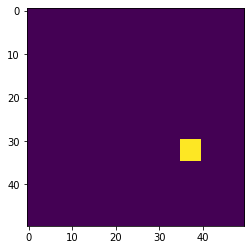

In [8]:
plt.imshow(create_true_mnistimage(9, (50, 50)))

In [9]:
mnist = tf.keras.datasets.mnist

image_shape = (28, 28)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.array(list(map(lambda image: cv2.resize(image, dsize=image_shape), x_train)))
x_test = np.array(list(map(lambda image: cv2.resize(image, dsize=image_shape), x_test)))
y_train_image = np.array(list(map(lambda y_label : create_true_mnistimage(y_label, image_shape), y_train)))
y_test_image = np.array(list(map(lambda y_label : create_true_mnistimage(y_label, image_shape), y_test)))
x_train = x_train/255.0
x_test = x_test/255.0

11501568/11490434 [==============================] - 0s 0us/step


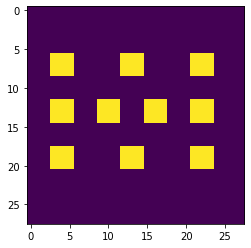

In [10]:
detector = CxD2NNMNISTDetector(10)
detector.plot_area((28, 28), same_color=True)

In [11]:
def loss(y_hat, y):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_hat, logits=y)

def loss_MSE(y_hat, y):
    return tf.reduce_sum((y_hat - y)**2)

In [12]:
l = 633e-9
k = 2 * np.pi / l
d = 1e-6


In [16]:
inputs = keras.Input(image_shape)
x = InputToCx(image_shape)(inputs)
x = CxMO(image_shape)(x)
x = FreeSpacePropagation(image_shape, k, 1.0e-4, normalization='max')(x)
x = CxD2NNIntensity(image_shape, normalization='max')(x)
x = CxD2NNMNISTDetector(10, activation='softmax')(x)
model = tf.keras.Model(inputs, x)
model.summary()
model.compile(optimizer='adam', 
              loss="sparse_categorical_crossentropy",   # category: sparse_categorical_crossentropy
              metrics=['accuracy'])

epochs = 10
early_stopping =  EarlyStopping(
                            monitor='accuracy',
                            min_delta=0.05,
                            patience=2,
)

result = model.fit(x_train, 
                   y_train, 
                   batch_size=64, 
                   epochs=epochs
                   #callbacks=[early_stopping]
                   )
model.save("28x28_6(MO_frspc100um)")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  # This is added back by InteractiveShellApp.init_path()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 input_to_cx_2 (InputToCx)   (None, 2, 28, 28)         0         
                                                                 
 cx_mo_3 (CxMO)              (None, 2, 28, 28)         784       
                                                                 
 free_space_propagation_1 (F  (None, 2, 28, 28)        1229312   
 reeSpacePropagation)                                            
                                                                 
 cx_mo_4 (CxMO)              (None, 2, 28, 28)         784       
                                                                 
 cx_d2nn_intensity_1 (CxD2NN  (None, 28, 28)           0         
 Intensity)                                                

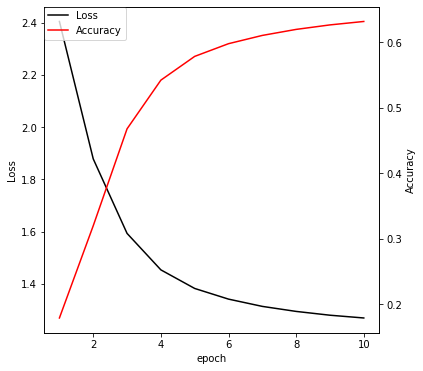

In [17]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, epochs + 1), result.history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, epochs + 1), result.history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

In [18]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 1.2101 - accuracy: 0.6427


[1.2101221084594727, 0.6427000164985657]

In [19]:
layer_name = model.layers[-2].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
hidden_layer_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 input_to_cx_2 (InputToCx)   (None, 2, 28, 28)         0         
                                                                 
 cx_mo_3 (CxMO)              (None, 2, 28, 28)         784       
                                                                 
 free_space_propagation_1 (F  (None, 2, 28, 28)        1229312   
 reeSpacePropagation)                                            
                                                                 
 cx_mo_4 (CxMO)              (None, 2, 28, 28)         784       
                                                                 
 cx_d2nn_intensity_1 (CxD2NN  (None, 28, 28)           0         
 Intensity)                                                

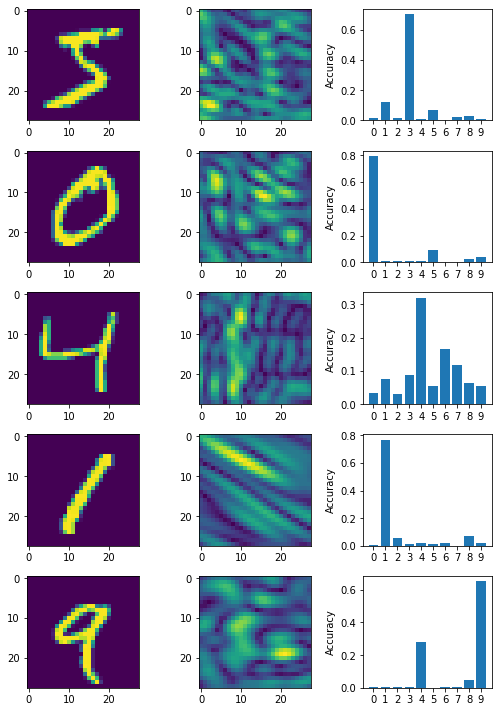

In [20]:
num = 5
images = x_train[0:num,:,:]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
fig, axes = plt.subplots(num, 3, figsize=(7,10))
for i in range(num):
  axes[i,0].imshow(images[i,:,:])
  axes[i,1].imshow(pred_images[i, :, :])
  axes[i,2].bar(np.arange(0, 10, 1), preds[i,:], align='center')
  axes[i,2].set_xticks(np.arange(0, 10, 1))
  axes[i,2].set_ylabel('Accuracy')
fig.tight_layout()

In [26]:
layer_outputs = [layer.output for layer in model.layers[1:]]
layer_outputs

[<KerasTensor: shape=(None, 2, 28, 28) dtype=float32 (created by layer 'input_to_cx_2')>,
 <KerasTensor: shape=(None, 2, 28, 28) dtype=float32 (created by layer 'cx_mo_3')>,
 <KerasTensor: shape=(None, 2, 28, 28) dtype=float32 (created by layer 'free_space_propagation_1')>,
 <KerasTensor: shape=(None, 2, 28, 28) dtype=float32 (created by layer 'cx_mo_4')>,
 <KerasTensor: shape=(None, 28, 28) dtype=float32 (created by layer 'cx_d2nn_intensity_1')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'cx_d2nnmnist_detector_2')>]

In [27]:
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
activation_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 input_to_cx_2 (InputToCx)   (None, 2, 28, 28)         0         
                                                                 
 cx_mo_3 (CxMO)              (None, 2, 28, 28)         784       
                                                                 
 free_space_propagation_1 (F  (None, 2, 28, 28)        1229312   
 reeSpacePropagation)                                            
                                                                 
 cx_mo_4 (CxMO)              (None, 2, 28, 28)         784       
                                                                 
 cx_d2nn_intensity_1 (CxD2NN  (None, 28, 28)           0         
 Intensity)                                                

In [31]:
num = 5
images = x_train[0:num,:,:]
activations = activation_model.predict(images)
len(activations)

6

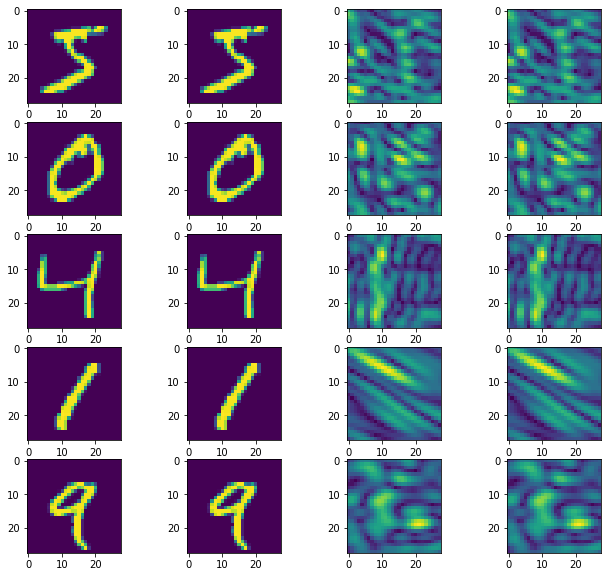

In [32]:
fig, axes = plt.subplots(num, len(activations)-2, figsize=(2*len(activations)-1, 2*num))
for i in range(len(activations)-2):
    layer_activation = activations[i]
    for j in range(num):
        intensity = tf.sqrt(layer_activation[j, 0, :, :]**2 + layer_activation[j, 1, :, :]**2)
        axes[j, i].imshow(intensity)